In [62]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *

 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display


import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools


# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *

# from pyspark.mllib.regression import LabeledPoint


from keras.models import Sequential
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout
from keras.layers.recurrent import LSTM


import scipy.stats as st

segment 0 : 290 92.2266345095 290
segment 1 : 580 2.92067017591 870
segment 2 : 970 98.8875861624 1840
1840


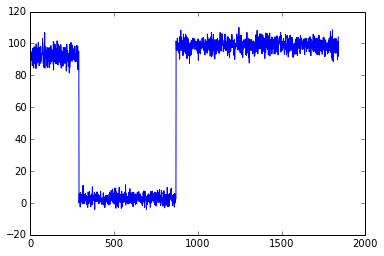

In [55]:
# block1: synthetic data

seg_num=3
seg_len_min= 100
seg_len_max=1000

mean_min=1
mean_max=100
var_min = 1
var_max=5

tcnt=0
ts=[]
true_cp_list=[]

for i in range(seg_num):
    seg_len = int(np.random.uniform([seg_len_min, seg_len_max, 1])[1])
    seg_mean = np.random.uniform([mean_min, mean_max, 1])[1]
    seg_var = np.random.uniform([var_min, var_max, 1])[1]
    
    print "segment",i,":",seg_len, seg_mean, tcnt+seg_len
    
    tmp= np.random.normal( seg_mean, seg_var, seg_len )
#     print len(tmp)
    
    true_cp_list.append( tcnt )
    tcnt= tcnt + seg_len   

    
    [ts.append(i) for i in tmp]
    
#     for j in range(seg_len):
#         ts.append( np.random.normal( seg_mean, seg_var, 1 )  )
        
print len(ts)

plt.plot(ts)

In [56]:
# block2: data pre-processing

import pandas as pd
from random import random
import numpy as np


# parameter
seg_num=1

tmptrnx =[]
tmptrny =[]

def extract_load_data( ts_df, st_idx, ed_idx):
    tmpdta = ts_df.iloc[st_idx: ed_idx]
    cnt= len(tmpdta)
    tmpx=[]
    tmpy=[]
    for i in range(cnt-1):
        tmpx.append( tmpdta.iloc[i].as_matrix() )
        tmpy.append( tmpdta.iloc[i+1].as_matrix() )

    return tmpx, tmpy, tmpdta.iloc[cnt-1].as_matrix()

ts_df= pd.DataFrame(ts)


# tmpPre = 0
# tmpCur=0
# for i in range(seg_num):
#     tmpCur = true_cp_list[i+1]
    
#     print tmpCur
    
#     tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
#     tmptrnx.append(tmpx)
#     tmptrny.append(tmpy)

#     tmpPre= tmpCur
    
tmpPre = 0
tmpCur = 1200
# true_cp_list[1]
    
tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
tmptrnx.append(tmpx)
tmptrny.append(tmpy)


# qualified format for rnn
dtax = np.array( tmptrnx )
dtay = np.array( tmptrny )

print dtax.shape, dtay.shape

(1, 1199, 1) (1, 1199, 1)


In [57]:
# block3: real-time rnn training on keras
from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense 
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop

# parameters
timesteps =1 
input_dim=1
in_out_neurons = 1 
hidden_neurons = 400
trn_size= dtax.shape[1]-1
trnx = dtax 
trny = dtay 

print trnx.shape, trny.shape

rl_model = Sequential()
rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps,input_dim ) ))
rl_model.add(TimeDistributedDense(output_dim=1 ) )
rl_model.add(Activation("linear")) 

rms = RMSprop(lr=0.04, rho=0.9, epsilon=1e-06)
rl_model.compile(loss="mean_squared_error", optimizer= rms )
#                  "rmsprop")

for i in range(trn_size): 
    cur_trnx= trnx[:,i:i+1,:] 
    cur_trny= trny[:,i:i+1,:]
    
#     print 'data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

    rl_model.train_on_batch(cur_trnx,cur_trny) 

    if i%20 ==0:
        vali_testx=  trnx[:, i+1:i+2,:]
        print "at time step:",i,":", rl_model.predict_on_batch( vali_testx ),\
        trnx[:, i+2:i+3,:]

    if i == trn_size-1:
        vali_testx=  trnx[:, i+1:i+2,:]
        print "at time step:",i,":", rl_model.predict_on_batch( vali_testx ),\
        trnx[:, i+2:i+3,:]
    
#     rl_model.fit(cur_trnx, cur_trny, batch_size=1, nb_epoch=10)
#     validation_split=0.05)

#     predicted = model.predict(X_test)
#     rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
#     model.predict( X_test[0:10] )

    
#     and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

(1, 1199, 1) (1, 1199, 1)
at time step: 0 : [array([[[ 13.66684151]]], dtype=float32)] [[[ 95.30649733]]]
at time step: 20 : [array([[[ 84.20682526]]], dtype=float32)] [[[ 97.9415651]]]
at time step: 40 : [array([[[ 91.68638611]]], dtype=float32)] [[[ 91.3551239]]]
at time step: 60 : [array([[[ 95.50965118]]], dtype=float32)] [[[ 88.31500364]]]
at time step: 80 : [array([[[ 92.48911285]]], dtype=float32)] [[[ 95.06581268]]]
at time step: 100 : [array([[[ 94.26474762]]], dtype=float32)] [[[ 90.94664025]]]
at time step: 120 : [array([[[ 89.53691101]]], dtype=float32)] [[[ 98.65984026]]]
at time step: 140 : [array([[[ 93.50161743]]], dtype=float32)] [[[ 89.07881086]]]
at time step: 160 : [array([[[ 95.80799866]]], dtype=float32)] [[[ 96.53740832]]]
at time step: 180 : [array([[[ 95.85580444]]], dtype=float32)] [[[ 97.3946391]]]
at time step: 200 : [array([[[ 89.38064575]]], dtype=float32)] [[[ 93.28581152]]]
at time step: 220 : [array([[[ 92.41944122]]], dtype=float32)] [[[ 95.56663612]]]

In [68]:
#  block4: change point detection based on real-time learning of rnn

significance_level = 0.05

cur_seg_stPos=0
cur_seg_cnt=0
ini_run_len=100


#  residual statistics
resi_mean=0.0
resi_sqr = 0.0
resi_var=0.0

# parameter about the hazard function
hconst = 0.3
hrange= seg_len_max
hpiece_num=50
hpiece =[]
hpiece_event=[]
hpiece_psum=[]


# detected change-points
detect_cp_list=[]


# data instances for training RNN
xtrain= dtax
ytrain= dtay
total_len=len(xtrain) 
print xtrain.shape, ytrain.shape


# initialize the network structure
in_dim = 1
hidden_neurons = 800
timesteps =1
input_dim=1

cp_model = Sequential()
cp_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
               batch_input_shape = (1,timesteps,input_dim )   ))
cp_model.add(Dropout(0.25))
cp_model.add(TimeDistributedDense(output_dim=1 ) )
cp_model.add(Activation("linear"))
rms = RMSprop(lr=0.04, rho=0.9, epsilon=1e-06)
cp_model.compile(loss="mean_squared_error", optimizer=rms )


# initialize the model
cur_trnx= xtrain[:,0:1,:]
cur_trny= ytrain[:,0:1,:]
cp_model.train_on_batch(cur_trnx,cur_trny) 



# ---------------hazard function component------------
def hazard_bsearch( arr, t):
    
    tmplen=len(arr)
    l= 0
    r= tmplen
    
    while( l< r-1):
        mid= int(l+ (r-l)/2.0)
        tmpval= arr[mid][0]
        
        if tmpval> t:
            r= mid
        else:
            l=mid
    
    if t<= arr[l][0]:
        return l
    elif t>= arr[r][0]:
        return r+1
    else:
        return r
    
def hazard_constant():
    return hconst
    
def hazard_piece_ini():
    tmpinter = hrange*1.0 / hpiece_num
    tmph = 1.0 / hpiece_num
    curh=0.0
    
    for i in range(hpiece_num):
        curh= curh+ tmph
        hpiece.append(  [tmpinter*(i+1), curh ]  )
        
        hpiece_event.append(  [tmpinter*(i+1), 0 ]  )
        hpiece_psum.append(  0  )
            
def hazard_piece_qry( cond_t ):
    tmpidx = hazard_bsearch( hpiece, cond_t)
    return hpiece[tmpidx][1]
    
def hazard_update_event( t):
    tmpidx = hazard_bsearch( hpiece_event, t)
    hpiece_event[tmpidx][1] = hpiece_event[tmpidx][1]+1

def hazard_update_piece():
    
    tmp_psum=[]
    tmp=0.0
    tmpsum=0.0
    for i in range(hpiece_num):
        tmp = tmp+ hpiece_event[i][1]
        tmp_psum.append(tmp)
    
    tmpsum= tmp
    
    for i in range(hpiece_num):
        if (tmpsum- tmp_psum[i]+hpiece_event[i][1])!=0 and hpiece_event[i][1]!=0:
            hpiece[i][1] =  hpiece_event[i][1]*1.0/(tmpsum-tmp_psum[i]+hpiece_event[i][1])
    
def hazard_adjust_piece():
    return 1
    
    

#-------------------run-lenght  joint distribution ---------------------

rlen_dist=[]

def rlen_dist_ini():
    for i in range(seg_len_max):
        rlen_dist.append(0)
    rlen_dist[0]=1

def rlen_update( cur_rlen, pred_prob):
    
    rlen_dist[ cur_rlen ] = rlen_dist[ cur_rlen-1 ]*pred_prob* ( 1.0- hazard_piece_qry( cur_rlen-1 )) 
    
    rlen_dist[ 0 ] = rlen_dist[ cur_rlen-1 ]*pred_prob* ( hazard_piece_qry( cur_rlen-1 )) 

    
def rlen_evidence():
    tmpval=0.0
    for i in range(seg_len_max):
        tmpval =  tmpval + rlen_dist[i]
    return tmpval
    
def rlen_conditional(cur_rlen):
    
    return rlen_dist[cur_rlen]/rlen_evidence()

def rlen_renormal():
    return 1
   
# normalize the run-lenght distribution    
    
# --------------------------------------------------------------------
    
hazard_piece_ini()
# print hpiece

    
# the main process
for i in range(1,400):
    
    
#   current data instance for training the model
    cur_trnx= xtrain[:,i:i+1,:]
    cur_trny= ytrain[:,i:i+1,:]
    
#       use so-far training model to predict first 
    vali_testx=  xtrain[:, i:i+1,:]
    curPred= cp_model.predict_on_batch( vali_testx )
    
#       residual of the current data instance w.r.t. the predicted value
    tmpresi =  curPred[0][0][0][0] - ytrain[0, i, 0]
    
    
    if i - cur_seg_stPos <=  ini_run_len:
        
        resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
        cur_seg_cnt = cur_seg_cnt+1
        resi_sqr = resi_sqr + tmpresi*tmpresi
        resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean 
        
#         if i - cur_seg_stPos>= ini_run_len-10:
#             resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
#             cur_seg_cnt = cur_seg_cnt+1
#             resi_sqr = resi_sqr + tmpresi*tmpresi
#             resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean         
        
        
#       update the model for the current segment
        cp_model.train_on_batch(cur_trnx, cur_trny)
    
        print "initial phase:", tmpresi, resi_mean,resi_var
#         curPred[0][0][0][0],ytrain[0, i, 0]

        continue
        
#       z-value
    resi_mean=0.0
    tmp_zval = (tmpresi -  resi_mean)*1.0 / 1.0*sqrt(resi_var/cur_seg_cnt)
    tmp_pro =  st.norm.cdf( tmp_zval)
        
    print "at time step:",cur_seg_cnt,":", curPred[0][0][0][0], ytrain[0, i, 0], resi_mean,resi_var,tmp_pro
#     curPred, ytrain[:, i:i+1,:], tmp_zval   
    
    
#---------------test component------------------------


    resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
    cur_seg_cnt = cur_seg_cnt+1
    resi_sqr = resi_sqr + tmpresi*tmpresi
    resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean             
        
    cp_model.train_on_batch(cur_trnx, cur_trny) 
    
    
#------------------------------------------------------    
        
#     if tmp_pro <= significance_level or tmp_pro >= 1.0-significance_level:
# #       initialize a new segment 
#         cur_seg_stPos =i
#         cur_seg_cnt = 1
            
#         resi_mean= x[i]
#         resi_sqr = x[i]*x[i]*1.0
#         resi_var =  0.0
            
#         detect_cp_list.append(i)
            
#         cp_model.reset_states()
#         cp_model.clear_previous(reset_weights=True)
        
# #       initialize a model for the new segment
#         cp_model.train_on_batch(cur_trnx,cur_trny) 
    
# #       update the hazard component
#         hazard_update_event(  i - cur_seg_stPos )
            
#     else:
        
# #      stay in the current segment and update the residual statistics 
#         resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/cur_seg_cnt
#         cur_seg_cnt = cur_seg_cnt+1
#         resi_sqr = resi_sqr + tmpresi*tmpresi
#         resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean             
        
# #       update the model for the current segment
#         cp_model.train_on_batch(cur_trnx, cur_trny) 
    
            
            


(1, 1199, 1) (1, 1199, 1)
initial phase: -76.7947938353 -76.7947938353 0.0
initial phase: -53.4075701424 -65.1011819888 136.740558016
initial phase: -41.9843688224 -57.3955776 209.913050004
initial phase: -31.5724386969 -50.9397928743 282.46625678
initial phase: -27.6329274402 -46.2784197874 312.886601642
initial phase: -16.2994517972 -41.2819251224 385.56362939
initial phase: -13.4446427229 -37.3051704939 425.370575158
initial phase: -13.6869056117 -34.3528873836 433.211082206
initial phase: -9.93739862192 -31.640055299 443.952180871
initial phase: 3.3546980001 -28.1405799691 509.773911046
initial phase: -0.556618743818 -25.6329471304 526.313052759
initial phase: -5.1331661923 -23.9246320522 514.555376165
initial phase: -8.96691181512 -22.7740381879 490.860588273
initial phase: -1.30015601468 -21.2401894612 486.384112593
initial phase: 5.80054614165 -19.4374737543 499.455479964
initial phase: 3.60899710138 -17.9970693259 499.36098623
initial phase: -6.69499840672 -17.3322416247 477.05

In [15]:
# block3: parameter selection for real-time rnn training on keras
from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense 
from keras.layers.recurrent import LSTM

# parameters
timesteps =1 
input_dim=1
in_out_neurons = 1 
hidden_neurons = 10000
trn_size= 2 
# dtax.shape[1]-10
trnx = dtax 
trny = dtay 

print trnx.shape, trny.shape


for num in range(3500,4000,200):
    
    print 'number of hidden neurons:', num

    
    rl_model = Sequential()
    rl_model.add(LSTM( num, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps,input_dim ) ))
    rl_model.add(TimeDistributedDense(output_dim=1 ) )
    rl_model.add(Activation("linear")) 
    rl_model.compile(loss="mean_squared_error", optimizer="rmsprop")
    
    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
    
        print '     data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

        rl_model.train_on_batch(cur_trnx,cur_trny) 

#     if i%50 ==0:
#         vali_testx=  trnx[:, i+1:i+2,:]
#         print "at time step:",i,":", rl_model.predict_on_batch( vali_testx )

#     if i == trn_size-1:
#         vali_testx=  trnx[:, i+1:i+2,:]
#         print "at time step:",i,":", rl_model.predict_on_batch( vali_testx )
    
        rl_model.fit(cur_trnx, cur_trny, batch_size=1, nb_epoch=10)
#     validation_split=0.05)

#     predicted = model.predict(X_test)
#     rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
#     model.predict( X_test[0:10] )

    
#     and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

(1, 799, 1) (1, 799, 1)
number of hidden neurons: 3500
     data instance: 0 of size: (1, 1, 1) (1, 1, 1)
Epoch 1/10
1/1 [==============================] - 1s - loss: 466818.3750
Epoch 2/10
1/1 [==============================] - 1s - loss: 461521.3750
Epoch 3/10
1/1 [==============================] - 1s - loss: 458589.4375
Epoch 4/10
1/1 [==============================] - 1s - loss: 456356.2500
Epoch 5/10
1/1 [==============================] - 1s - loss: 454472.1562
Epoch 6/10
1/1 [==============================] - 1s - loss: 452797.9062
Epoch 7/10
1/1 [==============================] - 1s - loss: 451244.1250
Epoch 8/10
1/1 [==============================] - 1s - loss: 449809.9375
Epoch 9/10
1/1 [==============================] - 1s - loss: 448446.7812
Epoch 10/10
1/1 [==============================] - 1s - loss: 447134.6562
     data instance: 1 of size: (1, 1, 1) (1, 1, 1)
Epoch 1/10
1/1 [==============================] - 1s - loss: 446011.2812
Epoch 2/10
1/1 [=======================

KeyboardInterrupt: 

In [78]:
#  hazard comopnent test

# parameter about the hazard function
# hconst = 0.3
# hpiece_num=50

# hrange= seg_len_max
# hpiece =[]
# hpiece_event=[]
# hpiece_psum=[]


def hazard_bsearch( arr, t):
    
    tmplen=len(arr)
    l= 0
    r= tmplen
    
    while( l< r-1):
        mid= int(l+ (r-l)/2.0)
        tmpval= arr[mid][0]
        
        if tmpval> t:
            r= mid
        else:
            l=mid
    
    if t<= arr[l][0]:
        return l
    elif t>= arr[r][0]:
        return r+1
    else:
        return r
    
def hazard_constant():
    return hconst
    
def hazard_piece_ini():
    tmpinter = hrange*1.0 / hpiece_num
    tmph = 1.0 / hpiece_num
    curh=0.0
    
    for i in range(hpiece_num):
        curh= curh+ tmph
        hpiece.append(  [tmpinter*(i+1), curh ]  )
        
        hpiece_event.append(  [tmpinter*(i+1), 0 ]  )
        hpiece_psum.append(  0  )
            
def hazard_piece_qry( cond_t ):
    tmpidx = hazard_bsearch( hpiece, cond_t)
    return hpiece[tmpidx][1]
    
def hazard_update_event( t):
    tmpidx = hazard_bsearch( hpiece_event, t)
    hpiece_event[tmpidx][1] = hpiece_event[tmpidx][1]+1

def hazard_update_piece():

#   mechanism for keepting default values
    tmp_psum=[]
    tmp=0.0
    tmpsum=0.0
    for i in range(hpiece_num):
        tmp = tmp+ hpiece_event[i][1]
        tmp_psum.append(tmp)
    
    tmpsum= tmp
    
    for i in range(hpiece_num):
        hpiece[i][1] =  hpiece_event[i][1]*1.0/(tmpsum- tmp_psum[i]+hpiece_event[i][1])
    
    

    
# ...................test.........................

# print hazard_constant()
# hazard_piece_ini()
# print hpiece
# hazard_piece_qry(201)

# hazard_update_event(4130)    
print hpiece_event
    
hazard_update_piece()

print hpiece

[[200.0, 12], [400.0, 0], [600.0, 5], [800.0, 0], [1000.0, 0], [1200.0, 0], [1400.0, 0], [1600.0, 0], [1800.0, 0], [2000.0, 0], [2200.0, 0], [2400.0, 0], [2600.0, 0], [2800.0, 0], [3000.0, 0], [3200.0, 0], [3400.0, 0], [3600.0, 0], [3800.0, 0], [4000.0, 0], [4200.0, 14], [4400.0, 0], [4600.0, 0], [4800.0, 0], [5000.0, 0], [5200.0, 0], [5400.0, 0], [5600.0, 0], [5800.0, 0], [6000.0, 0], [6200.0, 0], [6400.0, 0], [6600.0, 0], [6800.0, 0], [7000.0, 0], [7200.0, 0], [7400.0, 0], [7600.0, 0], [7800.0, 0], [8000.0, 0], [8200.0, 0], [8400.0, 0], [8600.0, 0], [8800.0, 0], [9000.0, 0], [9200.0, 0], [9400.0, 0], [9600.0, 0], [9800.0, 0], [10000.0, 5]]
36.0
[[200.0, 0.3333333333333333], [400.0, 0.0], [600.0, 0.20833333333333334], [800.0, 0.0], [1000.0, 0.0], [1200.0, 0.0], [1400.0, 0.0], [1600.0, 0.0], [1800.0, 0.0], [2000.0, 0.0], [2200.0, 0.0], [2400.0, 0.0], [2600.0, 0.0], [2800.0, 0.0], [3000.0, 0.0], [3200.0, 0.0], [3400.0, 0.0], [3600.0, 0.0], [3800.0, 0.0], [4000.0, 0.0], [4200.0, 0.736842

In [ ]:
#  keras: batch rnn training

from keras.models import Sequential
from keras.layers.core import Dense, Activation, TimeDistributedDense
from keras.layers.recurrent import LSTM
from keras.optimizers import *

in_out_neurons = 1
hidden_neurons = 2000

trnx= dtax[:, :2400,:]
trny= dtay[:, :2400,:]

batch_model = Sequential()
batch_model.add(LSTM(hidden_neurons,input_shape=trnx.shape[1:],return_sequences=True  ))

# batch_model.add(GRU(hidden_neurons,input_shape=trnx.shape[1:],return_sequences=True  ))

batch_model.add(TimeDistributedDense(output_dim=1 ) )
# model.add(Dense( output_dim= 1 , input_dim = hidden_neurons))
batch_model.add(Activation("linear"))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = RMSprop(lr=0.1, rho=0.9, epsilon=1e-06)
batch_model.compile(loss="mean_squared_error", optimizer=rmsprop)


batch_model.fit(trnx, trny, batch_size=1, nb_epoch=20)
#                 , validation_split=0.05)

# predicted = model.predict(X_test)
# rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

# model.predict( X_test[0:10] )

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")



In [90]:
#  keras: online mini-batch rnn training

from keras.models import Sequential
from keras.layers.core import Dense, Activation, TimeDistributedDense
from keras.layers.recurrent import LSTM

in_out_neurons = 1
hidden_neurons = 400


cur_trnx= trnx[:,:100,:]
cur_trny= trnx[:,:100,:]

print cur_trnx.shape, cur_trny.shape

ol_model = Sequential()
# model.add(LSTM(hidden_neurons,input_shape=trnx.shape[1:],return_sequences=True  ))

ol_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
               batch_input_shape = (1,100,1 )   ))

ol_model.add(TimeDistributedDense(output_dim=1 ) )
# model.add(Dense( output_dim= 1 , input_dim = hidden_neurons))
ol_model.add(Activation("linear"))
ol_model.compile(loss="mean_squared_error", optimizer="rmsprop")


dtax = np.array( tmptrnx )
dtay = np.array( tmptrny )


for i in range(4):
    ol_model.train_on_batch(cur_trnx,cur_trny) 

# model.fit(cur_trnx, cur_trny, batch_size=1, nb_epoch=10) 
#     validation_split=0.05)


# predicted = model.predict(X_test)
# rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

# model.predict( X_test[0:10] )

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")



(1, 100, 1) (1, 100, 1)


In [77]:
#  keras

# http://danielhnyk.cz/predicting-sequences-vectors-keras-using-rnn-lstm/

import pandas as pd
from random import random

flow = (list(range(1,10,1)) + list(range(10,1,-1)))*100
pdata = pd.DataFrame({"a":flow, "b":flow})
pdata.b = pdata.b.shift(9)
data = pdata.iloc[10:] * random()  # some noise

import numpy as np

def _load_data(data, n_prev = 10):
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1):
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

in_out_neurons = 2
hidden_neurons = 100

model = Sequential()
model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=False  ))

# model.add(LSTM(hidden_neurons, return_sequences=False, stateful= True,\
#                batch_input_shape = (100,10,2 )   ))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

(X_train, y_train), (X_test, y_test) = train_test_split(data)  # retrieve data

# X_train = X_train[0:1600]
# y_train = y_train[0:1600]

# print len(X_train[:100]), len(y_train[:100])

# model.train_on_batch(X_train[:100],y_train[:100] )
# model.train_on_batch(X_train[:100],y_train[:100],(100, 2) )
# model.train_on_batch(X_train[100:250],y_train[100:250],(150, 2) )

print X_train.shape, y_train.shape

model.fit(X_train, y_train, batch_size=100, nb_epoch=5) 
#           validation_split=0.05)


# predicted = model.predict(X_test)
# rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

model.predict( X_test[0:10] )

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: FutureWarning: slice indexers when using iloc should be integers and not floating point
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:36: FutureWarning: slice indexers when using iloc should be integers and not floating point


(1601, 10, 2) (1601, 2)
Epoch 1/5
1601/1601 [==============================] - 3s - loss: 1.8959     
Epoch 2/5
1601/1601 [==============================] - 3s - loss: 0.0813     
Epoch 3/5
1601/1601 [==============================] - 3s - loss: 0.0402     
Epoch 4/5
1601/1601 [==============================] - 3s - loss: 0.0374     
Epoch 5/5
1601/1601 [==============================] - 3s - loss: 0.0345     


array([[ 3.58813047,  1.00146997],
       [ 3.00854683,  1.5639205 ],
       [ 2.48745203,  2.13518548],
       [ 1.99927723,  2.64451599],
       [ 1.54009545,  3.11776543],
       [ 1.08250773,  3.59334445],
       [ 0.71006352,  4.01679468],
       [ 0.54891282,  4.19645119],
       [ 0.68129766,  4.03115988],
       [ 1.20303631,  3.5933826 ]])

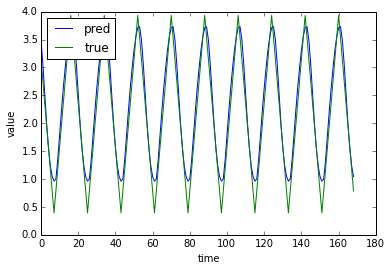

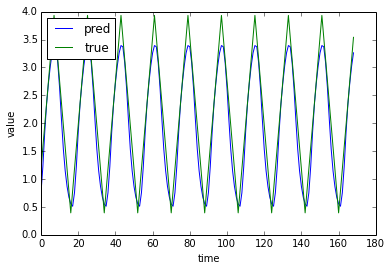

In [94]:
import matplotlib.pyplot as plt

tmpPre= [ i[0] for i in predicted  ]
tmpY= [ i[0] for i in y_test  ]
plt.plot(tmpPre, label = 'pred')
plt.plot( tmpY, label = 'true' )
plt.xlabel('time')
plt.ylabel('value')
plt.legend( loc='upper left',fontsize=12 )

plt.show()


import matplotlib.pyplot as plt

tmpPre= [ i[1] for i in predicted  ]
tmpY= [ i[1] for i in y_test  ]
plt.plot(tmpPre, label = 'pred')
plt.plot( tmpY, label = 'true' )
plt.xlabel('time')
plt.ylabel('value')
plt.legend( loc='upper left',fontsize=12 )

plt.show()





In [26]:
cnt = len(predicted)
plt.plot(range(0, cnt  ), predicted[:,0])
tmpplt= plt.plot(range(0, cnt  ),y_test[:,0])

plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

In [ ]:
# backup code 

max_lag = mini_batch = 50
significance_level = 0.05

cur_batch_cnt=0
cur_seg_stPos=0
cur_seg_cnt=0
total_len=len(ts) 
x=ts

# data instances for training RNN
xtrain=[]
ytrain=[]
# detected change-points
detect_cp_list=[]


ini_flag=1
ini_model=1

#  residual statistics
resi_mean=0.0
resi_sqr = 0.0
resi_var=0.0


# initialize the network structure
in_dim = 1
hidden_neurons = 100


cp_model = Sequential()
cp_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
               batch_input_shape = (1,timesteps,input_dim )   ))
cp_model.add(TimeDistributedDense(output_dim=1 ) )
cp_model.add(Activation("linear"))
cp_model.compile(loss="mean_squared_error", optimizer="rmsprop")

# seg_model = Sequential()
# seg_model.add(LSTM(hidden_neurons, input_dim=in_dim, return_sequences=False  ))
# seg_model.add(Dense(in_dim, input_dim=hidden_neurons))
# seg_model.add(Activation("linear"))
# seg_model.compile(loss="mean_squared_error", optimizer="rmsprop")


for i in range(total_len):
    
    if ini_flag==0 and ini_model ==0:
        
        xtest=[ []  ]
        for dta in x[i-1-max_lag: i]:
            tmplist=[]
            tmplist.append(dta  )
            xtest[0].append( tmplist ) 
         
        print seg_model.predict( np.array (xtest) )[0][0],  x[i]

        tmpresi =  seg_model.predict( np.array(xtest) )[0][0] - x[i]
        
#       z-value
        tmp_zval = (tmpresi -  resi_mean)*1.0 / sqrt(resi_var)
        tmp_pro =  st.norm.cdf( tmp_zval)
        
        print tmp_pro
        
        if tmp_pro <= significance_level or tmp_pro >= 1.0-significance_level:
            #initialize a new segment 
            cur_seg_stPos =i
            cur_seg_cnt = 1
            cur_batch_cnt =1
            
            resi_mean= x[i]
            resi_sqr = x[i]*x[i]*1.0
            resi_var =  0.0
            
            detect_cp_list.append(i)
            
            del xtrain[:]
            del ytrain[:]
            seg_model.clear_previous(reset_weights=True)
            
            ini_flag =1
            ini_model ==1
            
        else:
            #stay in the current segment and update the residual statistics 
            resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/cur_seg_cnt
            cur_seg_cnt = cur_seg_cnt+1
            resi_sqr = resi_sqr + tmpresi*tmpresi
            resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean 
            
            cur_batch_cnt =cur_batch_cnt+1
        
    
    if cur_batch_cnt < mini_batch:
        
        if ini_flag==0:
            
            xtrain.append( [])
            tmpcnt= len(xtrain)
            
#             print i, max_lag
            for dta in x[ i- max_lag: i-1]:
                tmplist=[]
                tmplist.append(dta)
                xtrain[tmpcnt-1].append( tmplist )
                
            tmplist=[]
            tmplist.append(x[i])
            ytrain.append( tmplist )
            
        cur_batch_cnt =cur_batch_cnt+1
            
    else:
        if ini_flag==1:
            ini_flag=0
            
            cur_batch_cnt=0
            continue
            
#         print len(xtrain),len(xtrain[0]), len(ytrain)
            
            
        seg_model.train_on_batch(np.array( xtrain),np.array( ytrain), nb_epoch=10  )
        ini_model=0
        
        cur_batch_cnt=0
        del xtrain[:]
        del ytrain[:]
        


In [ ]:
# backup code


#  tensorFlow

# '''
# A Reccurent Neural Network (LSTM) implementation example using TensorFlow library.
# This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
# Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf
# Author: Aymeric Damien
# Project: https://github.com/aymericdamien/TensorFlow-Examples/
# '''

# Import MINST data
import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np

# '''
# To classify images using a reccurent neural network, we consider every image row as a sequence of pixels.
# Because MNIST image shape is 28*28px, we will then handle 28 sequences of 28 steps for every sample.
# '''

# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
# Tensorflow LSTM cell requires 2x n_hidden length (state & cell)
istate = tf.placeholder("float", [None, 2*n_hidden])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(_X, _istate, _weights, _biases):

    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']

pred = RNN(x, istate, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_xs = batch_xs.reshape((batch_size, n_steps, n_input))
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                       istate: np.zeros((batch_size, 2*n_hidden))})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys,
                                                istate: np.zeros((batch_size, 2*n_hidden))})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys,
                                             istate: np.zeros((batch_size, 2*n_hidden))})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                  ", Training Accuracy= " + "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    test_len = 256
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label,
                                                             istate: np.zeros((test_len, 2*n_hidden))})

print ts[6426]



In [31]:
# backup code

#  pybrain

# from __future__ import print_function
data = [1] * 3 + [2] * 3
data *= 3
print(data)

from pybrain.datasets import SequentialDataSet
from itertools import cycle



# flow = (list(range(1,10,1)) + list(range(10,1,-1)))*100
# pdata = pd.DataFrame({"a":flow, "b":flow})
# pdata.b = pdata.b.shift(9)
# data = pdata.iloc[10:] * random()  # some noise




ds = SequentialDataSet(1, 1)
for sample, next_sample in zip(data, cycle(data[1:])):
    ds.addSample(sample, next_sample)
    
print (ds)

# from pybrain.tools.shortcuts import buildNetwork
# from pybrain.structure.modules import LSTMLayer

# net = buildNetwork(1, 5, 1, 
#                    hiddenclass=LSTMLayer, outputbias=False, recurrent=True)


# from pybrain.supervised import RPropMinusTrainer
# from sys import stdout

# trainer = RPropMinusTrainer(net, dataset=ds)
# train_errors = [] # save errors for plotting later
# EPOCHS_PER_CYCLE = 5
# CYCLES = 100
# EPOCHS = EPOCHS_PER_CYCLE * CYCLES
# for i in xrange(CYCLES):
#     trainer.trainEpochs(EPOCHS_PER_CYCLE)
#     train_errors.append(trainer.testOnData())
#     epoch = (i+1) * EPOCHS_PER_CYCLE
#     print("\r epoch {}/{}".format(epoch, EPOCHS), end="")
#     stdout.flush()

# print()
# print("final error =", train_errors[-1])


# import matplotlib.pyplot as plt

# plt.plot(range(0, EPOCHS, EPOCHS_PER_CYCLE), train_errors)
# plt.xlabel('epoch')
# plt.ylabel('error')
# plt.show()

# for sample, target in ds.getSequenceIterator(0):
#     print("               sample = %4.1f" % sample)
#     print("predicted next sample = %4.1f" % net.activate(sample))
#     print("   actual next sample = %4.1f" % target)
#     print()

SyntaxError: invalid syntax (<ipython-input-31-61d5cc106070>, line 29)

In [9]:
# backup code

# keras
# https://github.com/Vict0rSch/deep_learning/tree/master/keras
# https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent

import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
np.random.seed(1234)


def data_power_consumption(path_to_dataset,
                           sequence_length=50,
                           ratio=1.0):

    max_values = ratio * 2049280

    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break

    print "Data loaded from csv. Formatting..."

    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print "Shift : ", result_mean
    print "Data  : ", result.shape

    row = round(0.9 * result.shape[0])
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]


def build_model():
    model = Sequential()
    layers = [1, 50, 100, 1]

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model


def run_network(model=None, data=None):
    global_start_time = time.time()
    epochs = 1
    ratio = 0.5
    sequence_length = 50
    path_to_dataset = 'household_power_consumption.txt'

    if data is None:
        print 'Loading data... '
        X_train, y_train, X_test, y_test = data_power_consumption(
            path_to_dataset, sequence_length, ratio)
    else:
        X_train, y_train, X_test, y_test = data

    print '\nData Loaded. Compiling...\n'

    if model is None:
        model = build_model()

    try:
        model.fit(
            X_train, y_train,
            batch_size=512, nb_epoch=epochs, validation_split=0.05)
        predicted = model.predict(X_test)
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print 'Training duration (s) : ', time.time() - global_start_time
        return model, y_test, 0

    try:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(y_test[:100, 0])
        plt.plot(predicted[:100, 0])
        plt.show()
    except Exception as e:
        print str(e)
    print 'Training duration (s) : ', time.time() - global_start_time
    
    return model, y_test, predicted

# block3: real-time rnn training on keras

from keras.models import Sequential
from keras.layers.core import Dense, Activation, TimeDistributedDense
from keras.layers.recurrent import LSTM


# parameters
timesteps =1
input_dim=1

in_out_neurons = 1
hidden_neurons = 500
trn_size= dtax.shape[1]-10

trnx = dtax
trny = dtay
print trnx.shape, trny.shape

rl_model = Sequential()
# model.add(LSTM(hidden_neurons,input_shape=trnx.shape[1:],return_sequences=True  ))

rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
               batch_input_shape = (1,timesteps,input_dim )   ))

rl_model.add(TimeDistributedDense(output_dim=1 ) )
# rl_model.add(Dense(  1 , input_dim = hidden_neurons))
rl_model.add(Activation("linear"))
rl_model.compile(loss="mean_squared_error", optimizer="rmsprop")


for i in range(trn_size):
    cur_trnx= trnx[:,i:i+1,:]
    cur_trny= trny[:,i:i+1,:]
#     print 'data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape
    rl_model.train_on_batch(cur_trnx,cur_trny) 
     
    if i%500 ==0:
        vali_testx=  trnx[:, i+1:i+2,:]
        print "at time step:",i,":", rl_model.predict_on_batch( vali_testx )
    
    if i == trn_size-1:
        vali_testx=  trnx[:, i+1:i+2,:]
        print "at time step:",i,":", rl_model.predict_on_batch( vali_testx )
#     rl_model.fit(cur_trnx, cur_trny, batch_size=1, nb_epoch=10) 
#     validation_split=0.05)



# predicted = model.predict(X_test)
# rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

# model.predict( X_test[0:10] )

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")



In [ ]:
#  build online-rnn learning framework


#  state-full lstm 
#  https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py

# Q&A:
#  stateful lstm
#  variational
#  time steps: maximum time lag?
#  if residula is not white gaussian 

#  septerate modeling on conditions
